#Lectura y procesamiento de los resultados de los mejores modelos ELM

En el presente archivo se leen los archivos excel que contienen resumenes de los modelos generados con las grillas de ELM. Se procesa dicha información para encontrar los mejores modelos.

In [1]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/Universidad/2020/Tesis_final/problema2/leer_procesar_modelos_NARX/results/

/content/gdrive/MyDrive/Universidad/2020/Tesis_final/problema2/leer_procesar_modelos_NARX/results


In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

summaryModelsELM1S = pd.read_excel('grilla_ELM_NARX_1STEPS.xlsx', header=0)
summaryModelsELM2S = pd.read_excel('grilla_ELM_NARX_2STEPS.xlsx', header=0)
summaryModelsELM3S = pd.read_excel('grilla_ELM_NARX_3STEPS.xlsx', header=0)
summaryModelsELM4S = pd.read_excel('grilla_ELM_NARX_4STEPS.xlsx', header=0)

grilla_ELM_NARX_AQP = pd.concat([summaryModelsELM1S, summaryModelsELM2S], ignore_index=True)
grilla_ELM_NARX_AQP = pd.concat([grilla_ELM_NARX_AQP, summaryModelsELM3S], ignore_index=True)
grilla_ELM_NARX_AQP = pd.concat([grilla_ELM_NARX_AQP, summaryModelsELM4S], ignore_index=True)

grilla_ELM_NARX_AQP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MAPE                    56 non-null     float64
 1   delayedSteps            56 non-null     int64  
 2   nameModel               56 non-null     object 
 3   nameConfiguration       56 non-null     object 
 4   timeTrain (in seconds)  56 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ KB


##La cantidad de modelos generados para el ELM NARX de DDFO fue de 56

In [4]:
rslt_df = grilla_ELM_NARX_AQP.sort_values('MAPE')
total = grilla_ELM_NARX_AQP['timeTrain (in seconds)'].sum()
print("Tiempo total: " + str(total))
grilla_ELM_NARX_AQP.describe()

Tiempo total: 0.4700000000000001


MAPE  delayedSteps  timeTrain (in seconds)
count   56.000000     56.000000               56.000000
mean    42.046550      2.500000                0.008393
std     17.391635      1.128152                0.010917
min     17.406786      1.000000                0.000000
25%     31.430857      1.750000                0.000000
50%     37.576090      2.500000                0.000000
75%     44.924960      3.250000                0.010000
max    103.349800      4.000000                0.030000

##La cantidad de segundos totales para ejecutar la grilla es aproximadamente 1, lo que equivale a 0 horas aproximadamente. Además se tienen las estadisticas resumen.

In [5]:
rslt_df.iloc[:45,:]

MAPE  ...  timeTrain (in seconds)
28  17.406786  ...                    0.00
1   23.264260  ...                    0.00
15  23.559057  ...                    0.00
49  26.815957  ...                    0.00
53  26.912954  ...                    0.01
29  27.560993  ...                    0.00
43  27.623644  ...                    0.00
33  28.007093  ...                    0.00
54  28.210598  ...                    0.03
48  28.507057  ...                    0.00
55  28.948238  ...                    0.03
50  29.550449  ...                    0.01
42  29.953587  ...                    0.00
47  30.827494  ...                    0.00
0   31.631978  ...                    0.03
52  31.805233  ...                    0.01
18  32.814021  ...                    0.00
46  32.969931  ...                    0.00
20  33.812629  ...                    0.01
14  33.844820  ...                    0.00
25  34.241596  ...                    0.01
51  34.318997  ...                    0.01
38  34.508971  ...                    0.01
22  35.720817  ...                    0.01
24  36.274107  ...                    0.01
41  36.469668  ...                    0.03
27  37.145413  ...                    0.03
26  37.460440  ...                    0.03
40  37.691739  ...                    0.03
23  39.000782  ...                    0.01
35  39.889295  ...                    0.00
21  40.084853  ...                    0.00
36  40.885824  ...                    0.01
7   41.471749  ...                    0.00
39  41.496833  ...                    0.01
19  41.996880  ...                    0.00
34  42.777567  ...                    0.00
13  42.952754  ...                    0.03
11  43.199423  ...                    0.02
37  43.816675  ...                    0.01
12  44.193441  ...                    0.03
10  44.726129  ...                    0.01
8   45.521455  ...                    0.01
9   45.800709  ...                    0.01
30  48.105228  ...                    0.00

[45 rows x 5 columns]

In [6]:
rslt_df.iloc[0,:]

MAPE                                                    17.4068
delayedSteps                                                  3
nameModel                     results/ELM_39_1_10_mse_3S.joblib
nameConfiguration         results/ELM_39_1_10_mse_3S_config.npy
timeTrain (in seconds)                                        0
Name: 28, dtype: object

In [7]:
import time


def _mean_squared_error(y, pred):
    return 0.5 * np.mean((y - pred) ** 2)


def _mean_abs_error(y, pred):
    return np.mean(np.abs(y - pred))


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def _identity(x):
    return x



def getActivation(name):
    return {
        'sigmoid': _sigmoid
    }[name]


def getLoss(name):
    return {
        'mse': _mean_squared_error,
        'mae': _mean_abs_error
    }[name]


class ELM:
    def __init__(self, num_input_nodes, num_hidden_units, num_out_units, activation='sigmoid',
                 loss='mse', beta_init=None, w_init=None, bias_init=None):
        self._num_input_nodes = num_input_nodes
        self._num_hidden_units = num_hidden_units
        self._num_out_units = num_out_units

        self._activation = getActivation(activation)
        self._loss = getLoss(loss)

        if isinstance(beta_init, np.ndarray):
            self._beta = beta_init
        else:
            self._beta = np.random.uniform(-1., 1., size=(self._num_hidden_units, self._num_out_units))

        if isinstance(w_init, np.ndarray):
            self._w = w_init
        else:
            self._w = np.random.uniform(-1, 1, size=(self._num_input_nodes, self._num_hidden_units))

        if isinstance(bias_init, np.ndarray):
            self._bias = bias_init
        else:
            self._bias = np.zeros(shape=(self._num_hidden_units,))

        #print('Bias shape:', self._bias.shape)
        #print('W shape:', self._w.shape)
        #print('Beta shape:', self._beta.shape)

    def fit(self, X, Y, display_time=False):
        H = self._activation(X.dot(self._w) + self._bias)

        # Moore–Penrose pseudo inverse
        if display_time:
            start = time.time()
        H_pinv = np.linalg.pinv(H)
        if display_time:
            stop = time.time()
            print(f'Train time: {stop-start}')

        self._beta = H_pinv.dot(Y)

        # print('Fit Beta shape:', self._beta.shape)

    def __call__(self, X):
        H = self._activation(X.dot(self._w) + self._bias)
        return H.dot(self._beta)

    def evaluate(self, X, Y):
        pred = self(X)

        # Loss (base on model setting)
        loss = self._loss(Y, pred)

        # Accuracy
        #acc = np.sum(np.argmax(pred, axis=-1) == np.argmax(Y, axis=-1)) / len(Y)

        # Unweighted Average Recall
        # TODO

        #return loss, acc, pred
        return loss, pred

##Por principio de parsimonia, se decide trabajar con un modelo que genera un MAPE de 18.1, pero que tiene pocos retardos, especificamente 1 retardo.

In [8]:
bestModel = rslt_df.iloc[0,:]
print(bestModel)

MAPE                                                    17.4068
delayedSteps                                                  3
nameModel                     results/ELM_39_1_10_mse_3S.joblib
nameConfiguration         results/ELM_39_1_10_mse_3S_config.npy
timeTrain (in seconds)                                        0
Name: 28, dtype: object


In [9]:
print(bestModel['nameConfiguration'])
print(bestModel['nameModel'])

results/ELM_39_1_10_mse_3S_config.npy
results/ELM_39_1_10_mse_3S.joblib


In [10]:
print(bestModel['nameConfiguration'].split("/")[1])
print(bestModel['nameModel'].split("/")[1])

ELM_39_1_10_mse_3S_config.npy
ELM_39_1_10_mse_3S.joblib


In [11]:
#para recuperar configDict
config=np.load(bestModel['nameConfiguration'].split("/")[1],allow_pickle='TRUE').item()
print(config)

#Para cargar modelo:
saved_model = load(bestModel['nameModel'].split("/")[1]) 

{'nInputs': 39, 'nOutputs': 1, 'nHiddenUnits': 10, 'Loss': 'mse', 'Delays': 3, 'PredictionHorizon': 1}


In [12]:
def cargarData1():
  trainDFScaled = pd.read_csv('data/trainDF_std.csv', header=0)
  testDFScaled = pd.read_csv('data/testDF_std.csv', header=0)
  trainDF = pd.read_csv('data/trainDF.csv', header=0)
  testDF = pd.read_csv('data/testDF.csv', header=0)
  return trainDFScaled, testDFScaled, trainDF, testDF


# calculate the error between an actual and predicted value
def mae(actual, predicted):
	# calculate abs difference
	return abs(actual - predicted)
 
def mape(actual,pred):
  return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_forecasts(predictions, testData):
  total_mae = 0.0
  total_mape = 0.0
  total_c = 0
  for i in range(len(predictions)):
    real = testData[i]
    predicted = predictions[i]
    # calculate error
    error_mae = mae(real, predicted)
    error_mape = mape(real, predicted)
    # update statistics
    total_mae += error_mae
    total_mape += error_mape
    total_c += 1
  # normalize summed absolute errors
  total_mae /= total_c
  total_mape /= total_c
  return total_mae, total_mape


def generateSupervisedData(data, delays, predictionHorizon, columnTarget = 12):
  X = list()
  y = list()
  cantidadFilas = data.shape[0]
  indexAux = 0
  indexTarget = 0
  for _, row in data.iterrows():
    end_row = indexAux + delays
    indexTarget = end_row - 1 + predictionHorizon
    if indexTarget <= cantidadFilas-1:
      salidaAux = data.iloc[indexTarget, columnTarget]
      xAux = data.iloc[indexAux:end_row, :].values
      #print(xAux.shape)
      #print(xAux)
      X.append(xAux)
      y.append(salidaAux)
      #print(salidaAux)
    indexAux = indexAux + 1
  X = np.array(X)
  y = np.array(y)
  return X, y

def generateFinalData(delays, predictionHorizon, trainDFScaled, testDFScaled, trainDF, testDF):
  trainXScaled, trainYScaled = generateSupervisedData(trainDFScaled, delays, predictionHorizon)
  testXScaled, testYScaled = generateSupervisedData(testDFScaled, delays, predictionHorizon)
  trainX, trainY = generateSupervisedData(trainDF, delays, predictionHorizon)
  testX, testY = generateSupervisedData(testDF, delays, predictionHorizon)
  #print("trainXScaled.shape: ", str(trainXScaled.shape))
  #print("trainYScaled.shape: ", str(trainYScaled.shape))
  #print("testXScaled.shape: ", str(testXScaled.shape))
  #print("testYScaled.shape: ", str(testYScaled.shape))
  #print("trainX.shape: ", str(trainX.shape))
  #print("trainY.shape: ", str(trainY.shape))
  #print("testX.shape: ", str(testX.shape))
  #print("testY.shape: ", str(testY.shape))
  return trainXScaled, trainY, testXScaled, testY



def reshapeXdata(trainXScaled, testXScaled):
  #reshape data
  trainXScaled = trainXScaled.reshape((trainXScaled.shape[0],trainXScaled.shape[1]*trainXScaled.shape[2]))
  #print("trainXScaled.shape: ", str(trainXScaled.shape))
  testXScaled = testXScaled.reshape((testXScaled.shape[0],testXScaled.shape[1]*testXScaled.shape[2]))
  #print("testXScaled.shape: ", str(testXScaled.shape))
  return trainXScaled, testXScaled


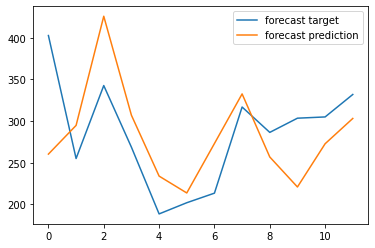

In [13]:
trainDFScaled, testDFScaled, trainDF, testDF = cargarData1()
trainXScaled, trainY, testXScaled, testY = generateFinalData(bestModel['delayedSteps'], 1, trainDFScaled, testDFScaled, trainDF, testDF)
trainXScaled, testXScaled = reshapeXdata(trainXScaled, testXScaled)
validation_target = testY[:]
val_loss, validation_predictions = saved_model.evaluate(testXScaled[:,:], validation_target)
fig, ax = plt.subplots(1, 1)
ax.plot(validation_target, label='forecast target')
ax.plot(validation_predictions, label='forecast prediction')
ax.legend()


##Generar data para NARMAX

In [14]:
def generateNarmaxData(dataScaled, data, delays, predictionHorizon, saved_model, columnTarget = 12):
  #Se hace una copia de los datos de entrada y agrega una columna con NA para los errores
  dataNarmax = data.copy()
  dataNarmax["error"] = np.nan
  dataNarmaxScaled = dataScaled.copy()
  dataNarmaxScaled["error"] = np.nan

  cantidadFilas = data.shape[0]
  indexAux = 0
  indexTarget = 0
  for _, row in data.iterrows():
    end_row = indexAux + delays
    indexTarget = end_row - 1 + predictionHorizon
    if indexTarget <= cantidadFilas-1:
      salidaAux = data.iloc[indexTarget, columnTarget]
      xAux = data.iloc[indexAux:end_row, :].values
      xAux = xAux.reshape(xAux.shape[0]*xAux.shape[1])
      loss, prediction = saved_model.evaluate(xAux, salidaAux)
      error = mape(salidaAux, prediction)
      dataNarmax.iloc[indexTarget, columnTarget+1] = error
      dataNarmaxScaled.iloc[indexTarget, columnTarget+1] = error
    indexAux = indexAux + 1
  dataNarmax = dataNarmax.dropna()
  dataNarmaxScaled = dataNarmaxScaled.dropna()
  return dataNarmax, dataNarmaxScaled

In [15]:
dataTrainNarmax, dataTrainNarmaxScaled = generateNarmaxData(trainDFScaled, trainDF, bestModel['delayedSteps'], 1, saved_model)
dataTestNarmax, dataTestNarmaxScaled = generateNarmaxData(testDFScaled, testDF, bestModel['delayedSteps'], 1, saved_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


In [16]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()

dataTrainNarmaxScaled[['error']] = std_scaler.fit_transform(dataTrainNarmaxScaled[['error']])
dataTestNarmaxScaled[['error']] = std_scaler.fit_transform(dataTestNarmaxScaled[['error']])

In [17]:
dataTrainNarmax.to_csv('dataTrainNarmaxELM.csv', index = False)
dataTrainNarmaxScaled.to_csv('dataTrainNarmaxScaledELM.csv', index = False)
dataTestNarmax.to_csv('dataTestNarmaxELM.csv', index = False)
dataTestNarmaxScaled.to_csv('dataTestNarmaxScaledELM.csv', index = False)

In [18]:
dataTrainNarmax.iloc[:10,[0,1,12,13]]

Week_of_the_month  Day_of_the_week  Target_(Total_orders)      error
3                 2.0              2.0                317.120  46.338952
4                 2.0              3.0                210.517  34.681753
5                 2.0              4.0                207.364  21.040536
6                 2.0              5.0                263.043   5.366636
7                 2.0              6.0                248.958  26.787720
8                 3.0              2.0                344.291  19.498459
9                 3.0              3.0                248.428  70.794513
10                3.0              4.0                281.420  28.118080
11                3.0              5.0                243.568  28.202898
12                3.0              6.0                308.178  53.665524

In [19]:
dataTestNarmaxScaled.iloc[:10,[0,1,12,13]]

Week_of_the_month  Day_of_the_week  Target_(Total_orders)     error
3           -0.013109         0.695422               1.144976  1.202986
4           -0.013109         1.414823              -0.515601  0.042111
5            0.773442        -1.462783               0.469686 -0.613690
6            0.773442        -0.743382              -0.362774 -0.131073
7            0.773442        -0.023980              -1.263585 -0.919027
8            0.773442         0.695422              -1.112536 -0.681933
9            0.773442         1.414823              -0.983254  1.863518
10           1.559993        -1.462783               0.179801 -1.230845
11           1.559993        -0.743382              -0.162757 -0.497137
12           1.559993        -0.023980               0.028966  0.618844

In [ ]:
print("trainDFScaled.shape = " + str(trainDFScaled.shape))
print("trainDF.shape = " + str(trainDF.shape))
print("testDFScaled.shape = " + str(testDFScaled.shape))
print("testDF.shape = " + str(testDF.shape))
#print("trainXScaled.shape = " + str(trainXScaled.shape))
#print("trainY.shape = " + str(trainY.shape))

trainDFScaled.shape = (24600, 46)
trainDF.shape = (24600, 46)
testDFScaled.shape = (14760, 46)
testDF.shape = (14760, 46)


In [ ]:
print("dataTrainNarmax.shape = " + str(dataTrainNarmax.shape))
print("dataTrainNarmaxScaled.shape = " + str(dataTrainNarmaxScaled.shape))
print("dataTestNarmax.shape = " + str(dataTestNarmax.shape))
print("dataTestNarmaxScaled.shape = " + str(dataTestNarmaxScaled.shape))

dataTrainNarmax.shape = (19065, 47)
dataTrainNarmaxScaled.shape = (19065, 47)
dataTestNarmax.shape = (9225, 47)
dataTestNarmaxScaled.shape = (9225, 47)
